In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate
import pickle
import time

from ga_utils import initialize_base_variables, split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package punkt to /Users/devasenan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
X_bow, y_score, logmodel = initialize_base_variables("../dataset/amazon.csv")
X_train, X_test, y_train, y_test = split(X_bow, y_score)

In [3]:
ga_path = '../pickles/ga/30runs/'
kbga_path = '../pickles/kbga/30runs/'
kb_path = "../pickles/kb/"
de_path = '../pickles/de/'
kbde_path = '../pickles/kbde/'


ga_files = ['30_run_az_ga_ts_pt.pkl',
            '30_run_imdb_ga_ts_pt.pkl',
            '30_run_yelp_ga_ts_pt.pkl',
            '30_run_az_ga_ts.pkl',
            '30_run_imdb_ga_ts.pkl',
            '30_run_yelp_ga_ts.pkl'
            ]

kb_files = ['30_run_az_kbip_ts_pt.pkl',
            '30_run_az_kbps_ts_pt.pkl',
            '30_run_az_kbco_ts_pt.pkl',
            '30_run_az_kbmu_ts_pt.pkl',
            ]

kbga_files = [
            '30_run_az_kbga_vp_ts.pkl',
            '30_run_az_kbga_es50_100_ts.pkl',
            '30_run_imdb_kbga_vp_ts.pkl',
            '30_run_imdb_kbga_es50_100_ts.pkl',
            '30_run_yelp_kbga_vp_ts.pkl',
            '30_run_yelp_kbga_es50_100_ts.pkl',
            ]

de_files = [
            '30_run_az_de.pkl',
            'n_run_az_de_crt.pkl',
            'n_run_az_de_crt1.pkl',
            ]

kbde_files = [
            '30_run_az_kbde.pkl',
            'n_run_az_kbde_crt.pkl',
            'n_run_az_kbde_crt1.pkl',
            ]

In [4]:
rf = open(ga_path+ga_files[0], 'rb')
ga_az = pickle.load(rf)

rf = open(kbga_path+kbga_files[0], 'rb')
kbga_az = pickle.load(rf)

# Collect Common indexes from res of single run evolution

In [5]:
def predicted_sentiment_ratio(y_test, predictions):
    positive_percent = np.count_nonzero(predictions==1)*100//len(predictions)
    negative_percent = np.count_nonzero(predictions==0)*100//len(predictions)
    # print(f"Y_test: pos/neg percentage ~ {np.count_nonzero(y_test==1)*100//len(y_test)}, {np.count_nonzero(y_test==0)*100//len(y_test)}")
    return positive_percent, negative_percent

In [6]:
def get_common_genes(file):
    common_features = []
    for i in range(len(file)):
        gen100_chromo = file[i][0][-1]
        common_features.extend(np.where(gen100_chromo == 1)[0])
    
    gene_freq = {}
    for i in range(len(common_features)):
        gene = common_features[i]
        gene_freq[gene] = gene_freq.setdefault(gene, 0) + 1

    sorted_gene_freq = np.array(sorted(gene_freq.items(), key=lambda x: x[1], reverse=True))
    return sorted_gene_freq

In [205]:
from sklearn.metrics import accuracy_score

def fs_model_comparison(sorted_gene_freq, freq_thresh, models, mode_count):
    if mode_count:
        selected_genes = sorted_gene_freq[:freq_thresh, 0]
    else:
        selected_genes = [gene for gene, count in sorted_gene_freq if count>=freq_thresh]

    exec_time = []
    accuracy = []
    for logmodel in models:
        # print(logmodel)
        st = time.time()
        logmodel.fit(X_train[:, selected_genes], y_train)
        et = time.time()
        exec_time.append(et-st)
        # exec_time.append("{:.3f}s".format(et-st))

        predictions = logmodel.predict(X_test[:, selected_genes])
        accuracy.append(accuracy_score(y_test, predictions))

    return selected_genes, accuracy, exec_time

In [207]:
from ga_utils import models, classifiers, acc_score

def tabulate_comparison(ga, kbga, freq_thresh=100, mode_count=True):
    model_res = acc_score(X_bow, y_score)

    temp_index = np.where(model_res['Classifier'] == 'MultinomialNB')[0][0]

    indeces = model_res.iloc[:, 0]
    accuracy = model_res.iloc[:, 1]
    exec_time = model_res.iloc[:, 2]

    sorted_classifiers = dict(zip(classifiers, models))
    sorted_models = sorted(sorted_classifiers.items(), key=lambda x: int(np.where(indeces == x[0])[0][0]))
    sorted_models = [j for i,j in sorted_models]
    
    sorted_models.pop(temp_index)
    indeces.pop(temp_index)
    accuracy.pop(temp_index)
    exec_time.pop(temp_index)

    sorted_gene_freq = get_common_genes(ga)
    ga_selected_features, ga_accuracy, ga_exec_time = fs_model_comparison(sorted_gene_freq, freq_thresh, sorted_models, mode_count)
    ga_selected_features.sort()

    sorted_gene_freq = get_common_genes(kbga)
    kbga_selected_features, kbga_accuracy, kbga_exec_time = fs_model_comparison(sorted_gene_freq, freq_thresh, sorted_models, mode_count)
    kbga_selected_features.sort()

    print('Actual, total number of features count:', X_bow.shape[1])
    print("Threshold for gene's frequency:", freq_thresh)
    print('Selected features count from GA:', len(ga_selected_features))
    print('Selected features count from KBGA:', len(kbga_selected_features))

    table_data = {
        'index': indeces,
        'Accuracy': accuracy,
        'Training Time': list(map(lambda x: round(x, 3), exec_time)),
        'GA Accuracy': ga_accuracy,
        'GA - Training Time': list(map(lambda x: round(x, 3), ga_exec_time)),
        'KBGA Accuracy': kbga_accuracy,
        'KBGA - Training Time': list(map(lambda x: round(x, 3), kbga_exec_time)),
    }

    print(tabulate(table_data, headers='keys', tablefmt="simple_grid"))
    return table_data, ga_selected_features, kbga_selected_features

In [208]:
def plot_bargraphs(table, hues, ytick):
    bar_width = 0.25
    x = np.arange(len(table['index']))
    y = np.arange(0.0, ytick, 0.1)

    fig, ax = plt.subplots(figsize=(12,6))
    bar1 = ax.bar(x-bar_width, height=table[hues[0]], width=bar_width, label=hues[0])
    bar2 = ax.bar(x, height=table[hues[1]], width=bar_width, label=hues[1])
    bar3 = ax.bar(x+bar_width, height=table[hues[2]], width=bar_width, label=hues[2])

    ax.set_ylabel('Fitness Values')
    ax.set_xticks(x, table['index'])
    ax.set_yticks(y)
    ax.legend()

    ax.bar_label(bar1)
    ax.bar_label(bar2)
    ax.bar_label(bar3)

    # fig.tight_layout()

In [215]:
comparison_with_89 = tabulate_comparison(ga_az, kbga_az, 89)

Actual, total number of features count: 1553
Threshold for gene's frequency: 89
Selected features count from GA: 89
Selected features count from KBGA: 89
┌──────────────┬────────────┬─────────────────┬───────────────┬──────────────────────┬─────────────────┬────────────────────────┐
│ index        │   Accuracy │   Training Time │   GA Accuracy │   GA - Training Time │   KBGA Accuracy │   KBGA - Training Time │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ RandomForest │      0.8   │           0.692 │         0.868 │                0.238 │           0.896 │                  0.248 │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ LinearSVM    │      0.78  │           0.19  │         0.836 │                0.015 │           0.832 │                  0.016 │
├──────────────┼────────────┼─────────────────┼───────────────┼───

In [216]:
comparison_with_100 = tabulate_comparison(ga_az, kbga_az, 100)

Actual, total number of features count: 1553
Threshold for gene's frequency: 100
Selected features count from GA: 100
Selected features count from KBGA: 100
┌──────────────┬────────────┬─────────────────┬───────────────┬──────────────────────┬─────────────────┬────────────────────────┐
│ index        │   Accuracy │   Training Time │   GA Accuracy │   GA - Training Time │   KBGA Accuracy │   KBGA - Training Time │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ RandomForest │      0.8   │           0.666 │         0.868 │                0.249 │           0.884 │                  0.255 │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ LinearSVM    │      0.78  │           0.213 │         0.836 │                0.014 │           0.832 │                  0.015 │
├──────────────┼────────────┼─────────────────┼───────────────┼

In [217]:
comparison_with_150 = tabulate_comparison(ga_az, kbga_az, 150)

Actual, total number of features count: 1553
Threshold for gene's frequency: 150
Selected features count from GA: 150
Selected features count from KBGA: 150
┌──────────────┬────────────┬─────────────────┬───────────────┬──────────────────────┬─────────────────┬────────────────────────┐
│ index        │   Accuracy │   Training Time │   GA Accuracy │   GA - Training Time │   KBGA Accuracy │   KBGA - Training Time │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ RandomForest │      0.8   │           0.657 │         0.868 │                0.28  │           0.888 │                  0.285 │
├──────────────┼────────────┼─────────────────┼───────────────┼──────────────────────┼─────────────────┼────────────────────────┤
│ LinearSVM    │      0.78  │           0.211 │         0.836 │                0.019 │           0.844 │                  0.021 │
├──────────────┼────────────┼─────────────────┼───────────────┼

In [218]:
accuracy_score = ['Accuracy', 'GA Accuracy', 'KBGA Accuracy']
exec_time = ['Training Time', 'GA - Training Time', 'KBGA - Training Time']

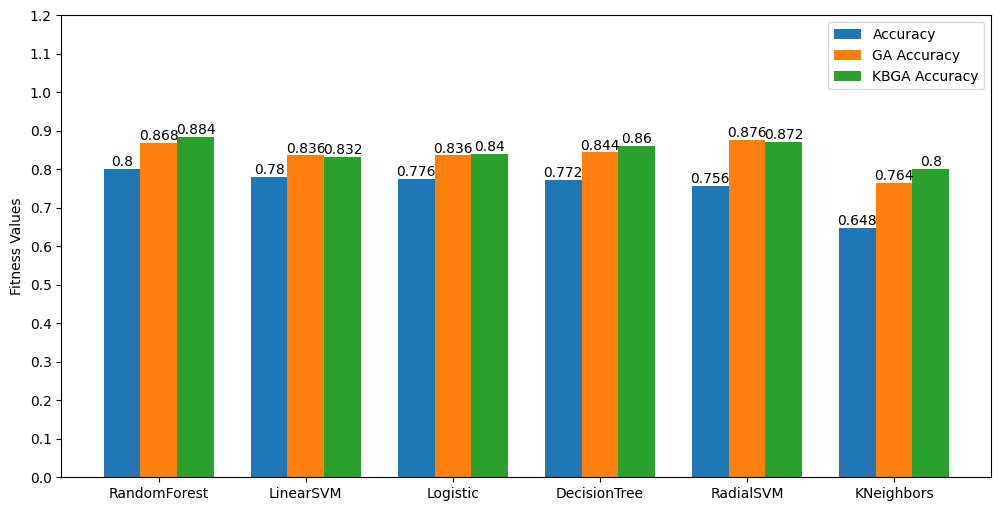

In [223]:
plot_bargraphs(comparison_with_100[0], accuracy_score, 1.25)

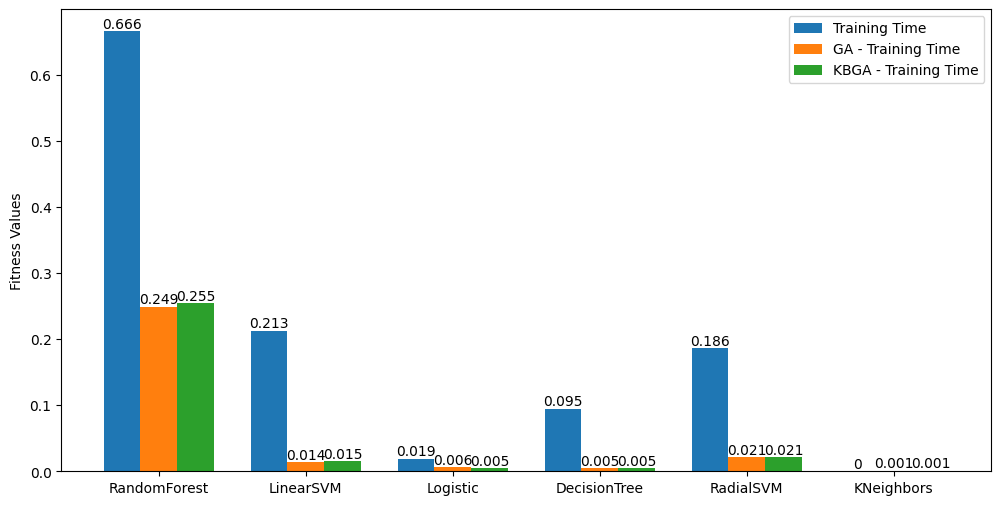

In [224]:
plot_bargraphs(comparison_with_100[0], exec_time, 0.7)